# Hobbies 🏃🎨📚🎻

John Fiocca

# Summary 

- I calculate the probability of a successful day of hobbies.
- I solve for what success rate would double my rate of perfect days.

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.ticker as ticker

sns.set_style('dark')
%matplotlib inline

Scipy 1.15 will have a `poisson_binom` distribution for handling multiple bernoulli trials with different probabilities. Until then I'll focus on other things and assume every hobby has the same success rate and use the binomial distribution.

In [2]:
running = 0.5
art = 0.5
literature = 0.5
music = 0.5

hobby_success_probabilities = [running, art, music, literature]

hobby_count = len(hobby_success_probabilities)
joint_probability = np.prod(hobby_success_probabilities)
average_probability = np.mean(hobby_success_probabilities)

### Visualizing the Distributions

This function is a great candidate to add to my `bindle` package.

In [3]:
def plot_discrete_distribution(drv, start=None, stop=None, x_max=None, highlight_color_index=0, colors=sns.palettes.color_palette('Set2'), **kwargs):
    """Plot a discrete distribution.

    Additional kwargs are passed to `sns.barplot`.

    """

    b = x_max if x_max is not None else drv.b

    x = np.arange(b + 1)
    y = [drv.pmf(i) for i in x]
    
    ax = sns.barplot(x=x, y=y, color=colors[-1], **kwargs)
    bars = ax.patches

    highlight_color = colors[highlight_color_index]

    # What if support doesn't start at zero?
    # if start is not None:
    #     start += drv.a

    if start is not None and stop is None:
        bars[start].set_facecolor(highlight_color)
        highlighted_probability = drv.pmf(start)
    elif stop is not None:
        highlight_slice = slice(start, stop+1)
        for b in bars[highlight_slice]:
            b.set_facecolor(highlight_color)    
        highlighted_probability = sum(drv.pmf(range(start, stop+1)))
    else:
        highlighted_probability = 0
    
    ax.set_title(f"Highlighted Probability: {highlighted_probability:.3f}")

    return ax

## Distributions

Binomial for probability of n successes.

Assuming each probability of success is the same and events are independent.

In [4]:
binom_rv = stats.binom(hobby_count, average_probability)

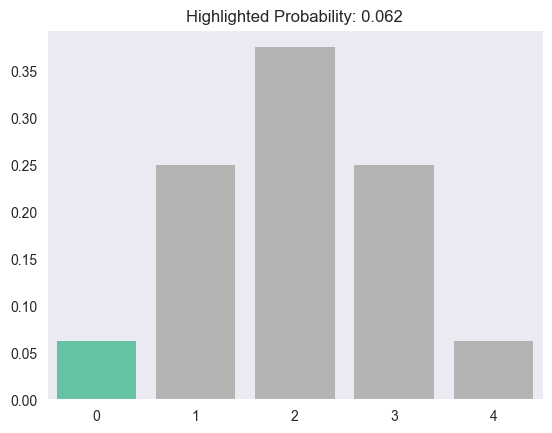

In [5]:
ax = plot_discrete_distribution(binom_rv, 0, 0, highlight_color_index=0, edgecolor='none')

### Geometric for time until a perfect day.

The probability of a perfect day is the same as a dud day, but that's what you save ice cream for.

#### What's the probability of a having to wait longer than expected for a perfect day?

In [6]:
geom_rv = stats.geom(joint_probability)

np.float64(16.0)

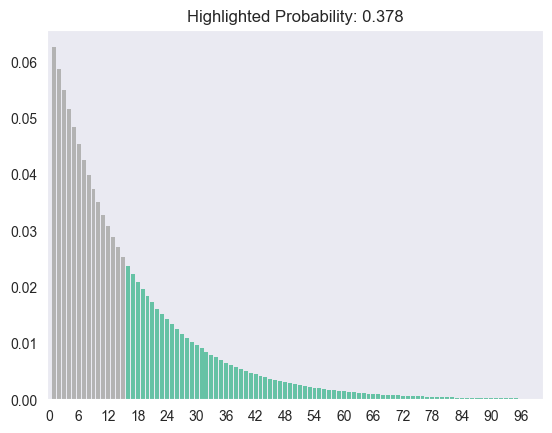

In [7]:
ax = plot_discrete_distribution(geom_rv, int(geom_rv.mean()), 100, x_max=100, edgecolor='none')
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))
geom_rv.mean() # Expected Value.

The negative binomial distribution can give us the probability of two perfect days in the same 16 day span. 

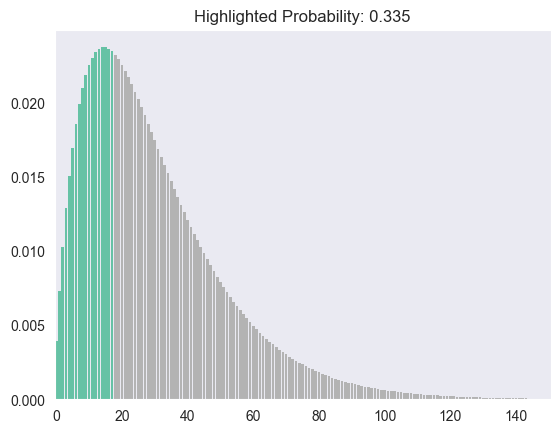

In [8]:
nbinom_rv = stats.nbinom(2, joint_probability)

ax = plot_discrete_distribution(nbinom_rv, 0, int(geom_rv.mean()) + 1, x_max=150, edgecolor='none')
ax.xaxis.set_major_locator(ticker.MaxNLocator(10))

## Question: What if I want to average 30 days without a dud day?

A dud day is where I fail at all my hobbies.

### Answer

A success probavility of 0.58 across all activities would double rate of perfect days.

In [9]:
from scipy.optimize import fsolve

def f(success_rate, days_until_dud, hobby_count):
    failure_rate = 1 - success_rate
    return stats.geom((failure_rate)**hobby_count).mean() - days_until_dud

root = fsolve(f, .5, args=(geom_rv.mean() * 2, 4))
root

array([0.57955179])

In [10]:
dudday_rv = stats.geom(((1 - root) ** 4).item())

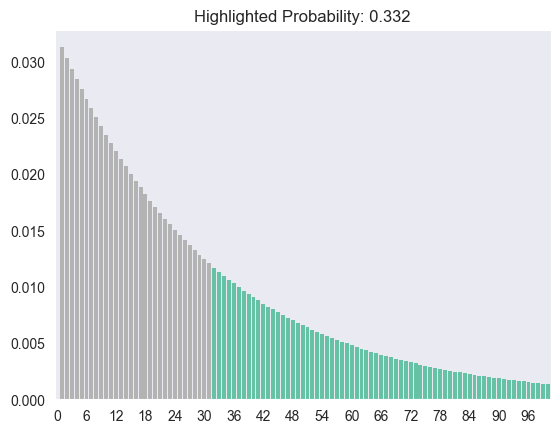

In [11]:
ax = plot_discrete_distribution(dudday_rv, round(dudday_rv.mean()), 100, x_max=100, edgecolor='none')
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))